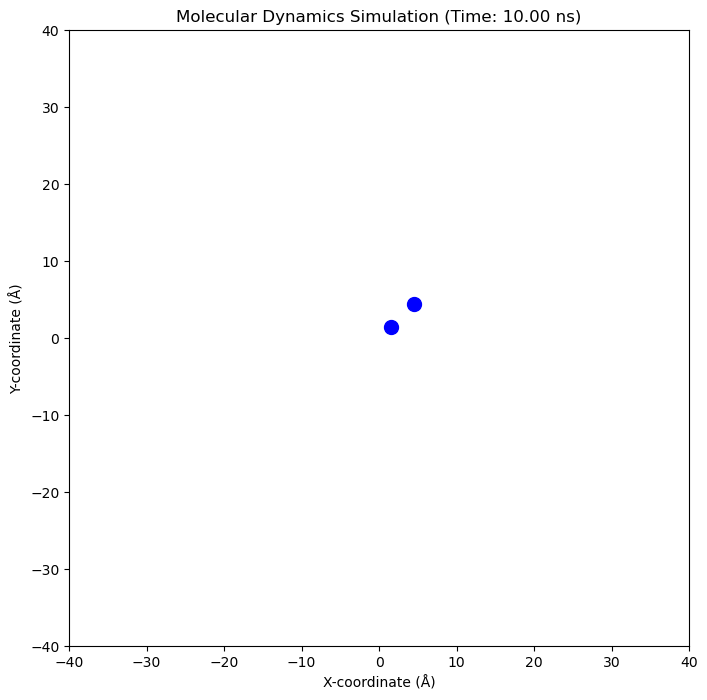

In [26]:
""" Molecular Dynamics Simulation
This code simulations the dynamics of atoms governed by the Lennard-Jones potential at the molecular scale
Authors: Borui Xu, Lucien Tsai, Yeqi Chu
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

box_size = 40  # Units in Å
total_time = 10  # Units in ns
total_steps = 1000
dt = total_time/total_steps

# Initial Atomic Positions
x_init = np.array([1, 5])
y_init = np.array([1, 5])
z_init = np.array([1, 1])

# Initial Atomic Veolcities
x_dot_init = np.array([0, 0])
y_dot_init = np.array([0, 0])
z_dot_init = np.array([0, 0])

# Atomic Masses
mass = np.array([1, 1])  # Units in AMU

# Lennard-Jones Parameters
well_depth = np.array([2, 2])  # Units in eV
zero_distance = np.array([4, 4])  # Units in Å

def force(atom_index: int, x: float, y: float, z: float, well_depth, zero_distance):
    """Computes the force on an atom from all other atoms
    Inputs:
        atom_index: index of the atom at which the force is computed
        x: x positions of all atoms
        y: y positions of all atoms
        z: z positions of all atoms
        well_depth: 1st Lennard-Jones parameter of all atoms
        zero_distance: 2nd Lennard-Jones parameter of all atoms
    Outputs:
        F_x: force in x direction
        F_y: force in y direction
        F_z: force in z direction
    """

    F_x: float = 0
    F_y: float = 0
    F_z: float = 0
    for other_index in range(len(x)):
        if other_index != atom_index:
            dx = x[atom_index] - x[other_index]
            dy = y[atom_index] - y[other_index]
            dz = z[atom_index] - z[other_index]
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            # Compute Lennard-Jones force, below formula to be filled
            # F = ??? 
            if r==0:
                continue
            epsilon_ij = np.sqrt(well_depth[atom_index] * well_depth[other_index])
            sigma_ij = (zero_distance[atom_index] + zero_distance[other_index]) / 2
            # Force magnitude
            F_mag = 4 * epsilon_ij * ((12 * (sigma_ij ** 12) / r ** 13) - (6 * (sigma_ij ** 6) / r ** 7))
            F_x += F_mag * dx / r
            F_y += F_mag * dy / r
            F_z += F_mag * dz / r
    return F_x, F_y, F_z


# Compute New Positions and Velocities

# Arrays to store positions at each step for all atoms

def verlet_integration(total_steps, x_init, y_init, z_init, x_all, y_all, z_all, mass, well_depth, zero_distance):
    num_atoms = len(mass)
    x_all = np.zeros((total_steps + 1, num_atoms))
    y_all = np.zeros((total_steps + 1, num_atoms))
    z_all = np.zeros((total_steps + 1, num_atoms))

    x_all[0, :] = x_init
    y_all[0, :] = y_init
    z_all[0, :] = z_init
    
    x_dot_all = np.zeros((total_steps + 1, num_atoms))
    y_dot_all = np.zeros((total_steps + 1, num_atoms))
    z_dot_all = np.zeros((total_steps + 1, num_atoms))
    
    x_dot_all[0, :] = x_dot_init
    y_dot_all[0, :] = y_dot_init
    z_dot_all[0, :] = z_dot_init
    # x_all = np.concatenate((x_init[None, :], np.zeros((total_steps, len(mass)))))
    # y_all = np.concatenate((y_init[None, :], np.zeros((total_steps, len(mass)))))
    # z_all = np.concatenate((z_init[None, :], np.zeros((total_steps, len(mass)))))

    # Compute initial forces
    F_x = np.zeros(num_atoms)
    F_y = np.zeros(num_atoms)
    F_z = np.zeros(num_atoms)
    
    for i in range(num_atoms):
        F_x[i], F_y[i], F_z[i] = force(i, x_all[0, :], y_all[0, :], z_all[0, :], well_depth, zero_distance)

    # old_x = x_init
    # old_y = y_init
    # old_z = z_init

    for step in range(1, total_steps + 1):  # Verlet Integration (w/o Velocities)
        
        # Update positions
        for i in range(num_atoms):
            x_all[step, i] = x_all[step - 1, i] + x_dot_all[step - 1, i] * dt + (F_x[i] / (2 * mass[i])) * dt ** 2
            y_all[step, i] = y_all[step - 1, i] + y_dot_all[step - 1, i] * dt + (F_y[i] / (2 * mass[i])) * dt ** 2
            z_all[step, i] = z_all[step - 1, i] + z_dot_all[step - 1, i] * dt + (F_z[i] / (2 * mass[i])) * dt ** 2

        # Compute new forces
        F_x_new = np.zeros(num_atoms)
        F_y_new = np.zeros(num_atoms)
        F_z_new = np.zeros(num_atoms)
        for i in range(num_atoms):
            F_x_new[i], F_y_new[i], F_z_new[i] = force(i, x_all[step, :], y_all[step, :], z_all[step, :], well_depth, zero_distance)

        # Update velocities
        for i in range(num_atoms):
            x_dot_all[step, i] = x_dot_all[step - 1, i] + ((F_x[i] + F_x_new[i]) / (2 * mass[i])) * dt
            y_dot_all[step, i] = y_dot_all[step - 1, i] + ((F_y[i] + F_y_new[i]) / (2 * mass[i])) * dt
            z_dot_all[step, i] = z_dot_all[step - 1, i] + ((F_z[i] + F_z_new[i]) / (2 * mass[i])) * dt

        # temp_x = old_x
        # temp_y = old_y
        # temp_z = old_z
        # for j in range(len(mass)):
        #     F_x, F_y, F_z = force(j, x_all, y_all, z_all, well_depth, zero_distance)
        #     x_ddot = F_x / mass[j]
        #     y_ddot = F_y / mass[j]
        #     z_ddot = F_z / mass[j]

        #     x_all[i][j] = x_all[j] * 2 - old_x[j] + x_ddot * dt * dt
        #     y_all[i][j] = y_all[j] * 2 - old_y[j] + y_ddot * dt * dt
        #     z_all[i][j] = z_all[j] * 2 - old_z[j] + z_ddot * dt * dt
        # old_x = temp_x
        # old_y = temp_y
        # old_z = temp_z
        
        F_x = F_x_new
        F_y = F_y_new
        F_z = F_z_new
        
    return x_all, y_all, z_all, x_dot_all, y_dot_all, z_dot_all

x_all, y_all, z_all, x_dot_all, y_dot_all, z_dot_all = verlet_integration(
    total_steps, x_init, y_init, z_init, x_dot_init, y_dot_init, z_dot_init, mass, well_depth, zero_distance
)

# Create a GIF animation of the atoms' positions over time
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-box_size, box_size)
ax.set_ylim(-box_size, box_size)
ax.set_xlabel('X-coordinate (Å)')
ax.set_ylabel('Y-coordinate (Å)')
ax.set_title('Molecular Dynamics Simulation')
scat = ax.scatter([], [], s=100)

def update(frame):
    ax.clear()
    ax.set_xlim(-box_size, box_size)
    ax.set_ylim(-box_size, box_size)
    ax.set_xlabel('X-coordinate (Å)')
    ax.set_ylabel('Y-coordinate (Å)')
    ax.set_title(f'Molecular Dynamics Simulation (Time: {frame * dt:.2f} ns)')
    scat = ax.scatter(x_all[frame, :], y_all[frame, :], s=100, c='blue')
    return scat,

ani = FuncAnimation(fig, update, frames=range(0, total_steps + 1, 10), interval=50, blit=True)

# Save the animation as a GIF file
ani.save('md_simulation.gif', writer='pillow', fps=20)
plt.show()